In [1]:
!pip install fbprophet
!pip install opendatasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

#!pip install fbprophet

import numpy             as np # linear algebra
import pandas            as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn           as sns
import opendatasets      as od
import gc

from fbprophet   import Prophet
from datetime    import datetime, date 
from functools   import reduce

import os

In [3]:
url="https://www.kaggle.com/competitions/jpx-tokyo-stock-exchange-prediction/data"
od.download(url)

Skipping, found downloaded files in "./jpx-tokyo-stock-exchange-prediction" (use force=True to force download)


#  **Load dataset**

In [4]:
df_stock_prices           = pd.read_csv('jpx-tokyo-stock-exchange-prediction/train_files/stock_prices.csv')

df_options                = pd.read_csv('jpx-tokyo-stock-exchange-prediction/train_files/options.csv')

df_secondary_stock_prices = pd.read_csv('jpx-tokyo-stock-exchange-prediction/train_files/secondary_stock_prices.csv')

df_trades                 = pd.read_csv('jpx-tokyo-stock-exchange-prediction/train_files/trades.csv')

df_financials             = pd.read_csv('jpx-tokyo-stock-exchange-prediction/train_files/financials.csv')

df_stock_list             = pd.read_csv('jpx-tokyo-stock-exchange-prediction/stock_list.csv')


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (7,8,9,10) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (14,15,16,17,18,19,42,44) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [5]:
gc.collect()

50

# **Function**

In [6]:
def explore_data (df):
    print("Missing values: \n", df.isnull().sum())
    print("\n \n")
    print(df.describe(include='all'))
    print("\n \n")
    print(df.info())
        

In [7]:
def plot_missing_val(df: pd.DataFrame):
    if df.isnull().sum().sum() != 0:
        na_df = (df.isnull().sum() / len(df)) * 100      
        na_df = na_df.drop(na_df[na_df == 0].index).sort_values(ascending=False)
        missing_data = pd.DataFrame({'Missing Ratio %' :na_df})
        missing_data.plot(kind = "barh", figsize=(10,5))
        plt.title("Percentage of missing values per feature")
        plt.show()
    else:
        print('No NAs found')

In [8]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

# Concatene dataframe

* Find shared keys

In [9]:
print(" Common columns between df_stock_prices and df_options -->", np.intersect1d(df_stock_prices.columns, df_options.columns) )

print("\n Common columns between df_stock_prices and df_trades -->", np.intersect1d(df_stock_prices.columns, df_trades.columns) )

print(" \n Common columns between df_stock_prices and df_secondary_stock_prices -->", np.intersect1d(df_stock_prices.columns, df_secondary_stock_prices.columns) )

print("\n Common columns between df_stock_prices and df_financials -->", np.intersect1d(df_stock_prices.columns, df_financials.columns) )

print("\n Common columns between df_stock_prices and df_stock_list -->", np.intersect1d(df_stock_prices.columns, df_stock_list.columns) )
      

 Common columns between df_stock_prices and df_options --> ['Date']

 Common columns between df_stock_prices and df_trades --> ['Date']
 
 Common columns between df_stock_prices and df_secondary_stock_prices --> ['AdjustmentFactor' 'Close' 'Date' 'ExpectedDividend' 'High' 'Low' 'Open'
 'RowId' 'SecuritiesCode' 'SupervisionFlag' 'Target' 'Volume']

 Common columns between df_stock_prices and df_financials --> ['Date' 'SecuritiesCode']

 Common columns between df_stock_prices and df_stock_list --> ['Close' 'SecuritiesCode']


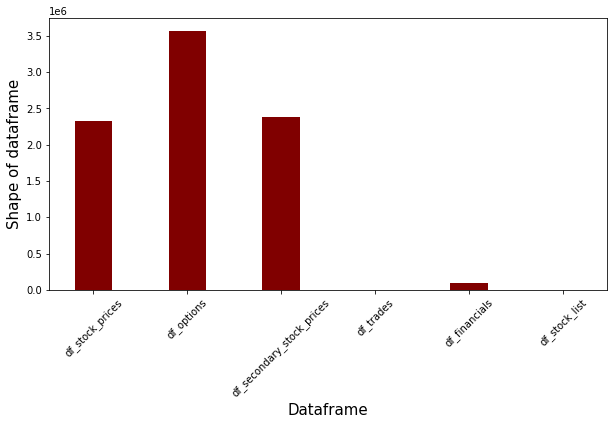

In [10]:
list_size_dfs = [df_stock_prices.shape[0], df_options.shape[0], df_secondary_stock_prices.shape[0], df_trades.shape[0], df_financials.shape[0], df_stock_list.shape[0]]
name_dfs      = ["df_stock_prices", "df_options", "df_secondary_stock_prices", "df_trades", "df_financials", "df_stock_list"]

fig = plt.figure(figsize = (10, 5))
# creating the bar plot
plt.bar(name_dfs,list_size_dfs, color ='maroon', width = 0.4)
plt.xlabel('Dataframe', fontsize='15')
plt.ylabel('Shape of dataframe', fontsize='15')
plt.xticks(rotation=45)
plt.show()

In [11]:
df_stock_new = df_stock_prices.append(df_secondary_stock_prices)

In [12]:
df_stock_new = reduce_mem_usage(df_stock_new)

Memory usage after optimization is: 238.42 MB
Decreased by 45.4%


In [13]:
gc.collect()

150

# **Data exploration**

In [14]:
df_stock_new.head()

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target
0,20170104_1301,2017-01-04,1301,2734.0,2755.0,2730.0,2742.0,31400,1.0,NaN,False,0.000731
1,20170104_1332,2017-01-04,1332,568.0,576.0,563.0,571.0,2798500,1.0,NaN,False,0.012321
2,20170104_1333,2017-01-04,1333,3150.0,3210.0,3140.0,3210.0,270800,1.0,NaN,False,0.006153
3,20170104_1376,2017-01-04,1376,1510.0,1550.0,1510.0,1550.0,11300,1.0,NaN,False,0.011055
4,20170104_1377,2017-01-04,1377,3270.0,3350.0,3270.0,3330.0,150800,1.0,NaN,False,0.003025


In [15]:
df_stock_new.describe(include='all')

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target
count,4717106,4717106,4.717106e+06,4.617747e+06,4.617747e+06,4.617747e+06,4.617747e+06,4.717106e+06,4.717106e+06,37323.0,4717106,4.716150e+06
unique,4717106,1202,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN
top,20170104_1301,2021-12-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN
freq,1,4090,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4702511,NaN
mean,NaN,NaN,5.557378e+03,5.899876e+03,5.955174e+03,5.842731e+03,5.898682e+03,4.616900e+05,NaN,inf,NaN,0.000000e+00
std,NaN,NaN,2.528957e+03,3.552297e+04,3.581771e+04,3.522635e+04,3.552194e+04,3.353114e+06,0.000000e+00,inf,NaN,0.000000e+00
min,NaN,NaN,1.301000e+03,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,9.997559e-02,0.0,NaN,-9.213867e-01
25%,NaN,NaN,3.390000e+03,7.130000e+02,7.210000e+02,7.030000e+02,7.120000e+02,6.000000e+03,1.000000e+00,0.0,NaN,-9.757996e-03
50%,NaN,NaN,5.821000e+03,1.395000e+03,1.411000e+03,1.376000e+03,1.394000e+03,3.660000e+04,1.000000e+00,10.0,NaN,0.000000e+00
75%,NaN,NaN,7.705000e+03,2.586000e+03,2.615000e+03,2.552000e+03,2.584000e+03,1.794000e+05,1.000000e+00,25.0,NaN,9.361267e-03


In [16]:
df_stock_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4717106 entries, 0 to 2384574
Data columns (total 12 columns):
 #   Column            Dtype  
---  ------            -----  
 0   RowId             object 
 1   Date              object 
 2   SecuritiesCode    int16  
 3   Open              float32
 4   High              float32
 5   Low               float32
 6   Close             float32
 7   Volume            int32  
 8   AdjustmentFactor  float16
 9   ExpectedDividend  float16
 10  SupervisionFlag   bool   
 11  Target            float16
dtypes: bool(1), float16(3), float32(4), int16(1), int32(1), object(2)
memory usage: 238.4+ MB


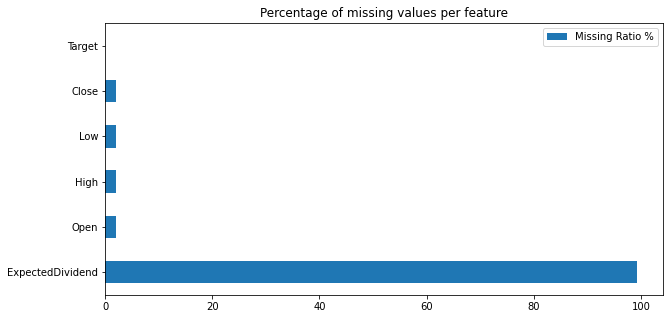

In [17]:
plot_missing_val(df_stock_new)

**Delete feature with more than 90% of missing values**

In [18]:
treshold = 90.0
min_count =  int(((100-treshold)/100)*df_stock_new.shape[0] + 1)
df_stock_new= df_stock_new.dropna( axis=1, 
                thresh=min_count)

In [19]:
gc.collect()

2895

In [20]:
#delete rows with missing values
df_stock_new.dropna(inplace=True)

In [21]:
print("number of missing values: ", df_stock_new.isnull().sum().sum())

number of missing values:  0


In [22]:
df_stock_new['Date'] = pd.to_datetime(df_stock_new['Date'], format = '%Y/%m/%d')
df_stock_new.head().style.set_properties(subset=['Date'], **{'background-color': 'yellow'})

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,SupervisionFlag,Target
0,20170104_1301,2017-01-04 00:00:00,1301,2734.000000,2755.000000,2730.000000,2742.000000,31400,1.000000,False,0.000731
1,20170104_1332,2017-01-04 00:00:00,1332,568.000000,576.000000,563.000000,571.000000,2798500,1.000000,False,0.012321
2,20170104_1333,2017-01-04 00:00:00,1333,3150.000000,3210.000000,3140.000000,3210.000000,270800,1.000000,False,0.006153
3,20170104_1376,2017-01-04 00:00:00,1376,1510.000000,1550.000000,1510.000000,1550.000000,11300,1.000000,False,0.011055
4,20170104_1377,2017-01-04 00:00:00,1377,3270.000000,3350.000000,3270.000000,3330.000000,150800,1.000000,False,0.003025


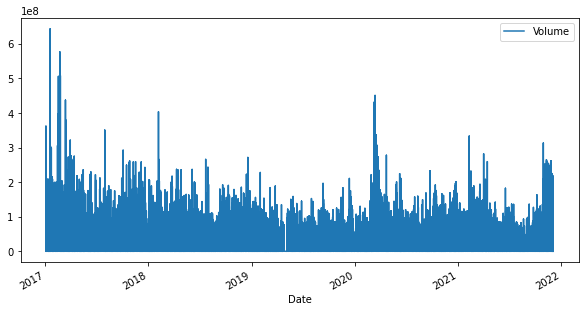

In [23]:
df_stock_new.plot(x='Date', y='Volume', figsize=(10,5), legend=True);

In [24]:
gc.collect()

2607

In [25]:

df_stock_new.SupervisionFlag = df_stock_new.SupervisionFlag.replace({True: 1, False: 0})

In [26]:
gc.collect()

100

In [27]:
df_stock_new = reduce_mem_usage(df_stock_new)

Memory usage after optimization is: 224.57 MB
Decreased by 12.1%


In [28]:
df_stock_new.head()

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,SupervisionFlag,Target
0,20170104_1301,2017-01-04,1301,2734.0,2755.0,2730.0,2742.0,31400,1.0,0,0.000731
1,20170104_1332,2017-01-04,1332,568.0,576.0,563.0,571.0,2798500,1.0,0,0.012321
2,20170104_1333,2017-01-04,1333,3150.0,3210.0,3140.0,3210.0,270800,1.0,0,0.006153
3,20170104_1376,2017-01-04,1376,1510.0,1550.0,1510.0,1550.0,11300,1.0,0,0.011055
4,20170104_1377,2017-01-04,1377,3270.0,3350.0,3270.0,3330.0,150800,1.0,0,0.003025


# **Data visualization**

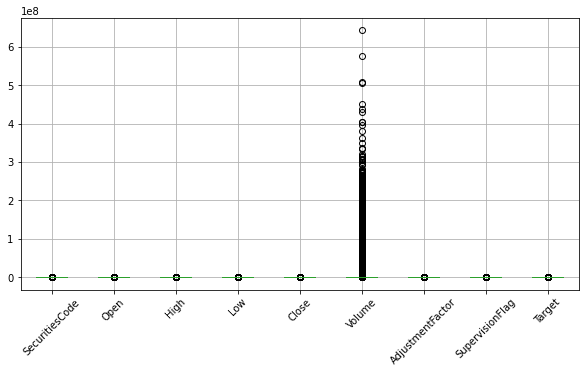

In [29]:
df_stock_new.boxplot(rot=45, figsize=(10,5));

In [30]:
gc.collect()

7344

# **Train/Test Split**

In [31]:
test_size = int((df_stock_new.shape[0] *80)/100)

df_train = df_stock_new[:test_size]
df_test = df_stock_new[test_size:]

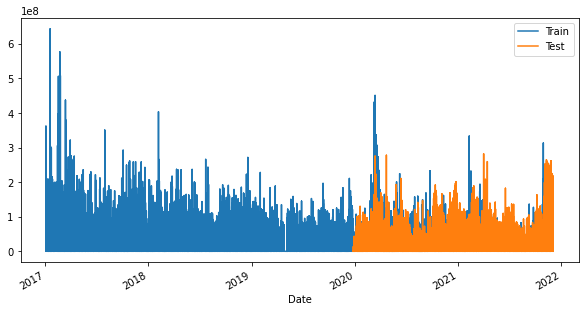

In [32]:
ax = df_train.plot(x='Date', y='Volume', figsize=(10,5), legend=True)
df_test.plot(x='Date', y='Volume', ax=ax)
ax.legend(["Train", "Test"]);

In [33]:
#Format data for prophet
df_train.rename(columns = {'Date':'ds', 'Target':'y'}, inplace = True)


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [34]:
df_train.drop(['RowId'], axis=1, inplace = True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [35]:
df_train.head()

,ds,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,SupervisionFlag,y
0,2017-01-04,1301,2734.0,2755.0,2730.0,2742.0,31400,1.0,0,0.000731
1,2017-01-04,1332,568.0,576.0,563.0,571.0,2798500,1.0,0,0.012321
2,2017-01-04,1333,3150.0,3210.0,3140.0,3210.0,270800,1.0,0,0.006153
3,2017-01-04,1376,1510.0,1550.0,1510.0,1550.0,11300,1.0,0,0.011055
4,2017-01-04,1377,3270.0,3350.0,3270.0,3330.0,150800,1.0,0,0.003025


# **Prophet model**

In [36]:
gc.collect()

337

In [ ]:
model = Prophet()
model.add_regressor('SecuritiesCode')
model.add_regressor('Open')
model.add_regressor('High')
model.add_regressor('Low')
model.add_regressor('Close')
model.add_regressor('Volume')
model.add_regressor('AdjustmentFactor')
model.add_regressor('SupervisionFlag')
model.fit(df_train)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
gc.collect()

In [ ]:
future_data = model.make_future_dataframe(periods=365)

In [ ]:
test_X = df_test.drop(['y'], axis=1)

In [ ]:
#forecast the data for Test  data
forecast_data = model.predict(test_X)
model.plot(forecast_data);

In [ ]:
#forecast = model.predict(future)

# To do:
    


* perform normalisation

* hyperparameter tuning




